
# Pendulum

https://www.gymlibrary.ml/environments/classic_control/pendulum/

The goal is to balance the pendulum in an inverted position. The pendulum starts in a random position. The only control you have is torque that you can apply at the pivot point. However, the magnitude of the torque is insufficient to overcome gravity on it's own.

![animation](https://www.gymlibrary.ml/_images/pendulum.gif)

In [3]:
%matplotlib ipympl

import gym
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [4]:
env_name = "Pendulum-v1"
episode_length = 200

## Define Agent

### Do Nothing
No input torque $(\tau = 0)$

You just see the pendulum swinging under the effects of gravity.

In [31]:
class Agent():
    def __init__(self, env):
        self.angle_integral = 0

    def get_action(self, state, phase):
        action = [0]
        return action

![animation](pendulum/pendulum_do_nothing.gif)

### Try to make it spin counter-clockwise

This agent has a fixed action of $\tau=2$

Note that the torque is insufficient to overcome gravity on it's own (without any build up of momentum).

Thus, this fixed action strategy to make the pendulum spin counter-clockwise may or may not work depending on the initial conditions.

In [37]:
class Agent():
    def __init__(self, env):
        self.angle_integral = 0

    def get_action(self, state, phase):
        action = [2]
        return action

![animation](pendulum/pendulum_fixed_action_1.gif)

### Apply torque in the direction of motion

Go either direction

In [167]:
class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state, phase):
        x, y, the_d = state
        the = np.arctan2(y, x)
        
        action = [0]
        if the_d > 0:
            action = [2]
        if the_d < 0:
            action = [-2]
    
        return action

![animation](pendulum/pendulum_direction_of_motion_action.gif)

Spin in a particular direction

In [38]:
direction = 'counter-clockwise' # 'counter' or 'counter-clockwise'

class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)
        action = [0]
        if direction == 'clockwise':
            if the_d < 0:
                action = [-2]
        if direction == 'counter-clockwise':
            if the_d > 0:
                action = [2]
    
        return action

### Swing Up + PD Controller

#### Only P Control
Only applying control proportional (the 'P' in 'PID') to the error, which in this case is the angle $\theta$. 

i.e. If the angle is positive, apply negative torque to make the angle return to 0. If the angle is negative, apply positive torque to make the angle return to 0.

This alone doesn't work in this case because the overshooting causes the pendulum to go past the angle at which max torque can recover it back to 0. 

Overshooting occurs because the force is continually applied all the way until $\theta$ goes past 0 (in either direction)

![animation](pendulum/pendulum_p_control.gif)

#### Only D Control
Only applying control proportional to the derivative (the 'D' in 'PID') of the error, which in this case is the anglular velocity $\omega$. 

i.e. If $\omega$ is positive, apply negative torque to make $\omega$ go to 0. If the $\omega$ is negative, apply positive torque to make the $\omega$ go to 0.

This does a good job of slowing the pendulum down but doesn't get it to the angle that we want ($\theta=0$)
![animation](pendulum/pendulum_d_control.gif)


#### Combining P and D
Combining the corrections based on both the angle and angular velocity allows you to balance the pendulum in the inverted position.

In [10]:
from enum import Enum

class Phase(Enum):
    DEFAULT = 0
    SWING_UP = 1
    ARREST = 2
    BALANCE = 3
    FINE_BALANCE = 4

class Fsm:
    def __init__(self):
        self.phase = Phase.SWING_UP

    def update_phase(self, observation):
        x, y, w = observation
        the = np.arctan2(y,x)
        a = w - state[len(state)-1][1] if len(state) > 0 else 0

        if abs(the) < 0.05:
            self.phase = Phase.FINE_BALANCE
        elif abs(the) < np.pi/2 and abs(w) > 3 and the * w < 0:
            self.phase = Phase.ARREST
        elif abs(the) < 0.55:
            self.phase = Phase.BALANCE
        elif abs(the) >= 1.8:
            self.phase = Phase.SWING_UP
        else:
            self.phase = Phase.DEFAULT
    
        return self.phase

kp = 8 # 8
kd = 5 # 5
ki = 0

class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state, phase):
        x, y, the_d = state
        the = np.arctan2(y, x)
        self.angle_integral += the
        
        if phase == phase.DEFAULT:
            action = [0] # Default do nothing
        elif phase == Phase.SWING_UP:
            if the_d > 0:
                action = [2]
            if the_d < 0:
                action = [-2]
        else:
            composite = (-1 * kp * the) + (-1 * kd * the_d) + (-1 * ki * the_int)
            action = [np.clip(composite, -2, 2)]

        return action


![animation](pendulum/pendulum_pd_control.gif)
![animation](pendulum/pendulum_pd_control_1.gif)

## Live Plot

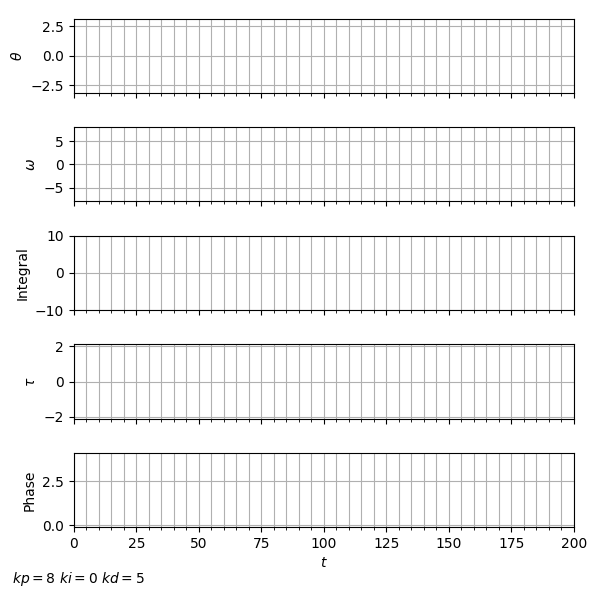

In [11]:
num_subplots = 5
fig, axes = plt.subplots(num_subplots,1)
lines = []

# Set common settings
for i, ax in enumerate(axes):
    ax.grid(visible=True, which="both")
    ax.set_xlim(0,episode_length)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
    lines.append(ax.plot([], []))
    if i != len(axes)-1:
        ax.get_xaxis().set_ticklabels([])

axes[0].set_ylabel(r'$\theta$')
axes[0].set_ylim(-np.pi, np.pi)
axes[1].set_ylabel(r'$\omega$')
axes[1].set_ylim(-8, 8)
axes[2].set_ylabel('Integral')
axes[2].set_ylim(-10, 10)
axes[3].set_ylabel(r'$\tau$')
axes[3].set_ylim(-2.1, 2.1)
axes[4].set_ylabel('Phase')
axes[4].set_ylim(-0.1, 4.1)

ax.set_xlabel(r'$t$')
annotation_text = ' '.join([f'$kp={kp}$', f'$ki={ki}$', f'$kd={kd}$'])
fig.text(0.02,0.02, annotation_text, va='bottom', ha='left',)

fig.tight_layout()
fig.set_size_inches(6,6)

state = []
frames = []

def plot_state(observation, the_int, action, phase, frame_no):
    x, y, w = observation
    the = np.arctan2(y,x)
    a = w - state[len(state)-1][1] if len(state) > 0 else 0 
    tau = action[0]
    state.append([the, w, the_int, tau, phase.value])
    frames.append(frame_no)
    
    transpose = np.array(state).T
    
    for i in range (num_subplots):
        lines[i][0].set_data(frames, transpose[i])

    fig.canvas.draw()

    # To save animation as gif
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data


## Run Environment

### Run without saving gif

In [7]:
env = gym.make(env_name)
agent = Agent(env)
rewards = list()

for i_episode in range(1):
    state.clear()
    frames.clear()
    fsm = Fsm()
    observation = env.reset()
    for t in range(200):
        env.render()
        phase = fsm.update_phase(observation)
        action = agent.get_action(observation, phase)
        the_int = agent.angle_integral
        plot_state(observation, the_int, action, phase, t)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(reward)
            
            break
            
print(f"Final Rewards:{rewards}")
env.close()


Episode finished after 200 timesteps
Final Rewards:[-0.13923240791967573]


In [123]:
plt.close('all')

### Run and save output to gif

In [12]:
from PIL import Image
import cv2
episode_length = 200
def process_and_save_images(img_env, img_plot):
    img_plot = cv2.resize(img_plot, (500,500))
    img_combined = np.concatenate([img_env, img_plot], axis=1)
    images.append(Image.fromarray(img_combined))

images = []
env = gym.make(env_name)
agent = Agent(env)
rewards = list()

for i_episode in range(1):
    state.clear()
    frames.clear()
    fsm = Fsm()
    observation = env.reset()
    for t in range(episode_length):
        img_env = env.render(mode='rgb_array')
        phase = fsm.update_phase(observation)
        action = agent.get_action(observation, phase)
        the_int = agent.angle_integral
        img_plot = plot_state(observation, the_int, action, phase, t)
        process_and_save_images(img_env, img_plot)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(reward)
            break
    
    images[0].save('pendulum/pendulum_pd_control.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=66, loop=0)
            
print(f"Final Rewards:{rewards}")
env.close()



Episode finished after 200 timesteps
Final Rewards:[-6.973116249384198e-07]
